<a href="https://colab.research.google.com/github/prips47/CCC_intern/blob/master/VariationalAutoEncoderImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
# Import the mnnist data

from tensorflow.examples.tutorials.mnist import input_data
#database=input_data.read_data_sets('/content/data',one_hot=True) #it says download the data, save it to the MNIST_data folder, and process it so that data is in one hot encoded format.
database=input_data.read_data_sets('/content/data1',one_hot=False) 

In [0]:
# Parameters for the neural network

learning_param=0.001
epochs=30000
batch_size=32

# Network parameters
image_dimension= 784 # no. of nodes in input layer; 784 bcz, image of size 28x28 in mnnist dataset
neural_network_dimension=512 # i.e. hidden layer of the neural network or (Encoder layer and Decoder layer)

#change this value for latent space effect on visulization of reconstructed data
latent_variable_dimension=2 # size of mu vector and sigma vector

#initilization
  # xavier initialization of the neural network; basically initilization with random weights such that neural activation function should not satuarate or become dead
def xavier (in_shape):
  val=tf.random_normal(shape=in_shape,stddev=1./tf.sqrt(in_shape[0]/2.))  # stddev is simply =1/pow(n,0.5)
  return (val)



In [0]:
# defining weight and biases dictionaries

Weight={ "weight_matrix_encoder_hidden": tf.Variable(xavier([image_dimension,neural_network_dimension])),
         "weight_mean_hidden":tf.Variable(xavier([neural_network_dimension])),
         "weight_std_hidden":tf.Variable(xavier([neural_network_dimension,latent_variable_dimension])),
         "weight_matrix_decoder_hidden":tf.Variable(xavier([latent_variable_dimension,neural_network_dimension])),
         "weight_decoder":tf.Variable(xavier([neural_network_dimension,image_dimension]))
       }

Bias={ "bias_matrix_encoder_hidden":tf.Variable(xavier([neural_network_dimension])),
         "bias_mean_hidden":tf.Variable(xavier([latent_variable_dimension])),
         "bias_std_hidden":tf.Variable(xavier([latent_variable_dimension])),
         "bias_matrix_decoder_hidden":tf.Variable(xavier([neural_network_dimension])),
         "bias_decoder":tf.Variable(xavier([image_dimension]))
     }

In [0]:
#Building the variational autoencoder

#Encoder Section

image_X=tf.placeholder(tf.float32,shape=[None,image_dimension])

Encoder_layer=tf.add(tf.matmul(image_X,Weight["weight_matrix_encoder_hidden"]),Bias["bias_matrix_encoder_hidden"])
Encoder_layer=tf.nn.tanh(Encoder_layer); # for non linearity

Mean_layer=tf.add(tf.matmul(Encoder_layer,Weight["weight_mean_hidden"]),Bias["bias_mean_hidden"])
Standard_deviation_layer=tf.add(tf.matmul(Encoder_layer,Weight["weight_std_hidden"]),Bias["bias_std_hidden"])


#Reparametrization trick
epsilon=tf.random_normal(tf.shape(Standard_deviation_layer),dtype=tf.float32,mean=0.0,stddev=1.0) # random normal ??

latent_layer=Mean_layer+tf.exp(0.5*Standard_deviation_layer)*epsilon  # Z= mu + (sigma^0.5)*epsilon; creating latent layer


#Deoder Section
Decoder_hidden=tf.add(tf.matmul(latent_layer,Weight["weight_matrix_decoder_hidden"]),Bias["bias_matrix_decoder_hidden"])
Decoder_hidden=tf.nn.tanh(Decoder_hidden) # ReLu can also be used here

Decoder_output_layer= tf.add(tf.matmul(Decoder_hidden,Weight["weight_decoder"]),Bias["bias_decoder"])
Decoder_output_layer=tf.nn.sigmoid(Decoder_output_layer)  # this is our reconstructed image at outside



In [0]:
#Definig the variational Autoencoder Loss

def loss_function(original_image,reconstructed_image):
  #Reconstruction_Loss
  data_fidality_loss=original_image*tf.log(1e-10 +reconstructed_image)+(1-original_image)*tf.log(1e-10+1-reconstructed_image)
  data_fidality_loss=-tf.reduce_sum(data_fidality_loss,1) #tf.reduce_sum(x, 1) ; rowwise sum
 
  
  #KL Divergence Loss
  KL_div_loss=1+Standard_deviation_layer-tf.square(Mean_layer)-tf.exp(Standard_deviation_layer)
  KL_div_loss= -0.5*tf.reduce_sum(KL_div_loss,1)
  
  #Depending on which loss you have to take, select values of alpha and beta
  #If only KL loss is to be evaluated, put alpha=0; If only fidality loss put beta=0; for VAE both should be 1
  alpha=1
  beta=1
  network_loss=tf.reduce_mean(alpha*data_fidality_loss + beta*KL_div_loss)
  return(network_loss)
loss_value=loss_function(image_X, Decoder_output_layer)
optimizer=tf.train.RMSPropOptimizer(learning_param).minimize(loss_value) #optimizing loss value

#Initialize all the variables 
init=tf.global_variables_initializer()



In [0]:
#Executing the computational Graph

#Start the session
sess=tf.Session()

#Run the initializer
sess.run(init)

for i in range(epochs+1):
  x_batch,_=database.train.next_batch(batch_size) # last column values will come on '_' and remaining column on X_batch
  _,loss=sess.run([optimizer,loss_value],feed_dict={image_X:x_batch}) #x_batch is of size 32x784
  if i %5000 == 0:
    print("Loss is {0} at interation {1}".format(loss,i)) # {0}:loss, {1}: iteration i

In [0]:
#Testing phase

# Noise input handle
noise_X=tf.placeholder(tf.float32,shape=[None,latent_variable_dimension])

#Rebuild the decoder to create output image from noise 

#Decoder section (repeat) ; repeated beacause we are generating new images from latent vector samples  

Decoder_hidden=tf.add(tf.matmul(noise_X,Weight["weight_matrix_decoder_hidden"]),Bias["bias_matrix_decoder_hidden"])
Decoder_hidden=tf.nn.tanh(Decoder_hidden)

Decoder_output_layer= tf.add(tf.matmul(Decoder_hidden,Weight["weight_decoder"]),Bias["bias_decoder"])
Decoder_output_layer=tf.nn.sigmoid(Decoder_output_layer)  # this is our reconstructed image at outside




Tensor("Placeholder_14:0", shape=(?, 2), dtype=float32)


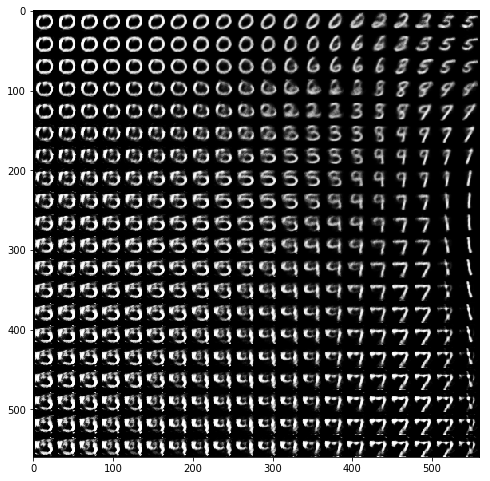

In [0]:
#output_visulization

n=20
x_limit=np.linspace(-2,2,n)
y_limit=np.linspace(-2,2,n)

empty_image=np.empty((28*n,28*n))

for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    generated_latent_layer=np.array([[zi,pi]]*batch_size)
    #generated_latent_layer=np.random.normal(0,1,size=[batch_size,latent_variable_dimension])
    generated_image=sess.run(Decoder_output_layer,feed_dict={noise_X:generated_latent_layer})
    empty_image[(n-i-1)*28:(n-i)*28,j*28:(j+1)*28]=generated_image[0].reshape(28,28)

plt.figure(figsize=(8,10))

X,y=np.meshgrid(x_limit,y_limit)
plt.imshow(empty_image,origin="upper",cmap="gray")
plt.show()

(10000, 784)
(10000, 2)


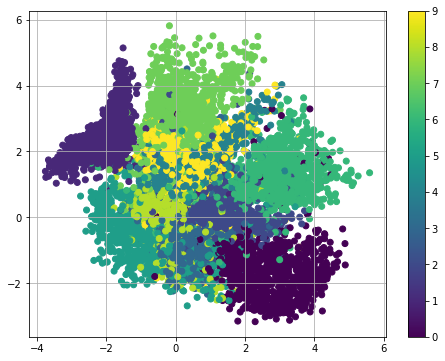

In [0]:
# Cost Function Visulization
x_sample,y_sample=database.test.next_batch(batch_size+15000)
print(x_sample.shape)

#run of the latent layer. please note that graph is possible onli in latent dimension of 2. 
#graph shows the gaussian distribution profile of the latent vectors as discussed in the theory.
interim=sess.run(latent_layer,feed_dict={image_X:x_sample})
print(interim.shape)

colors=np.argmax(y_sample,1)

plt.figure(figsize=(8,6))
plt.scatter(interim[:,0],interim[:,1],c=colors,cmap='viridis')
plt.colorbar()
plt.grid()
sess.close()